# 📊 ***Data Science, CA4 - Task 2*** 📚

* **Member 1** : [Kasra Kashani, 810101490] 🆔
* **Member 2** : [Borna Foroohari, 810101480] 🆔

📄 **Subjects**: Deep Learning: CNN

## 🔹**Imports**

Import required modules.

In [30]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.preprocessing import label_binarize

## 📍 Design a CNN Model to Classify Flower Species Images

In this project, we will use the **Flowers Multi-class Dataset from Kaggle to classify flower species.** So we will build a VGG-style CNN from scratch and fine-tune a pretrained ResNet, comparing how these approaches affect accuracy and reliability.

### 📤 1. Dataset Loading

First we download and load the dataset just once. Then we show some of them.

In [2]:
# Download the dataset from Kaggle

# path = kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")

# print("Path to dataset files:", path)

In [3]:
# Load all train, validation, and test images from the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flower_photos/train",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flower_photos/validation",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flower_photos/test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


In [4]:
# Show different classes of flowers in our dataset
class_names = train_ds.class_names

print("Flower classes:", class_names)

Flower classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
# Show the number of images in each class of flower

class_counts = collections.Counter()

for images, labels in train_ds.unbatch():
    label = labels.numpy()
    class_name = class_names[label]
    class_counts[class_name] += 1

print("Number of images in each flower class:")
for cls in class_names:
    print(f"{cls}: {class_counts[cls]}")

Number of images in each flower class:
daisy: 607
dandelion: 872
roses: 615
sunflowers: 673
tulips: 773


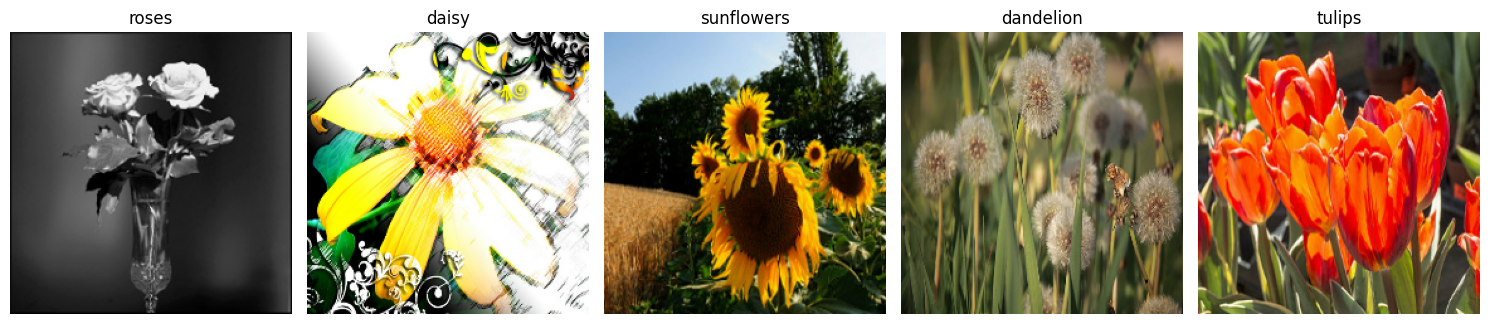

In [6]:
# Show a flower image from each class

plt.figure(figsize=(15, 8))

seen = set()
i = 1

for image, label in train_ds.unbatch():
    class_label = class_names[label.numpy()]

    if class_label not in seen:
        plt.subplot(1, len(class_names), i)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_label)
        plt.axis("off")

        seen.add(class_label)
        i += 1

    if len(seen) == len(class_names):
        break

plt.tight_layout()
plt.show()

### 🔄 2&3. Image Preprocessing & Data Augmentation

Now we prepare the images and labels so they’re ready for training.

Here, we **resize** all images to 224x224 pixels, because it is a common size for CNNs like VGG or ResNet. \
Also **normalize** them and scale pixel values to [0,1] by dividing by 255, because models perform better with smaller and normalized input values and also helps stabilize gradients during training, leading to more effective learning. \
For labels, we can choose a format between **label encoding** and **one-hot encoding**. We use one-hot encoding which no changes are needed.

Also we add variety to the **training set only**, so that the model learns patterns rather than memorizing the images, and can generalize better. So we apply some transformations like:
- Random rotations between -20° and 20°
- Horizontal flips with 50% chance
- Random crops (shifts) with 10% of image size
- Slight brightness or contrast changes with ±20%
- Zoom in with 90% to 110%

In [7]:
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_data = ImageDataGenerator(rescale=1./255)

test_data = ImageDataGenerator(rescale=1./255)

train_generator = train_data.flow_from_directory(
    "flower_photos/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_data.flow_from_directory(
    "flower_photos/validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_data.flow_from_directory(
    "flower_photos/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3540 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


### ⚙️ 4. Building a VGG CNN from Scratch

Now we can create and train a **VGG-style CNN**. \
VGG is a deep network with stacked convolutional layers (e.g., 3x3 filters), max-pooling layers, and fully connected layers at the end. bellow is the
VGG-16 architecture: \
(image from [geeksforgeeks](https://www.geeksforgeeks.org/vgg-16-cnn-model/))

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg" alt="ERR" width="1000">

Here’s a breakdown of the VGG-16 architecture:

0. Input Layer:
    - A standard 254x254 image with 3 channels for RGBs.
1. Convolutional Layers (64 filters, 3×3 filters, same padding):
    - Two consecutive convolutional layers with 64 filters each and a filter size of 3×3.
    - Same padding is applied to maintain spatial dimensions.
2. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
3. Convolutional Layers (128 filters, 3×3 filters, same padding):
    - Two consecutive convolutional layers with 128 filters each and a filter size of 3×3.
4. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
5. Convolutional Layers (256 filters, 3×3 filters, same padding):
    - Three consecutive convolutional layers with 256 filters each and a filter size of 3×3.
6. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
7. Convolutional Layers (512 filters, 3×3 filters, same padding):
    - Three sets of three consecutive convolutional layers with 512 filters each and a filter size of 3×3.
8. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
9. Convolutional Layers (512 filters, 3×3 filters, same padding):
    - Three sets of three consecutive convolutional layers with 512 filters each and a filter size of 3×3.
10. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
11. Flattening:
    - Flatten the output feature map.
12. Fully Connected Layers:
    - Three fully connected layers with ReLU activation.
    - First layer with input size 512 and output size 4096.
    - Second layer with input size 4096 and output size 4096.
    - Third layer with input size 4096 and output size 5, corresponding to the 5 classes in the Flowers dataset.
13. Softmax Layer:
    - Softmax activation is applied to the output of the third fully connected layer for classification.

First, we define our VGG-16 model from scratch.

In [8]:
def build_vgg_model(num_classes, input_shape=(224, 224, 3)):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3,3), activation='relu', padding='same'),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

Now we can train the model on our augmented training data for appropriate epochs.

In [9]:
model = build_vgg_model(num_classes=5)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,670,309 (197.11 MB)

 Trainable params: 51,670,309 (197.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint_vgg = ModelCheckpoint('best_vgg_model.keras', save_best_only=True, monitor='val_loss')

print("\tVGG training with Label Encoding")

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping_vgg, model_checkpoint_vgg]
)

model.load_weights('best_vgg_model.keras')

val_loss_vgg, val_acc_vgg = model.evaluate(validation_generator)

print(f"\nVGG final -> Validation Accuracy: {val_acc_vgg:.4f}, Validation Loss: {val_loss_vgg:.4f}")

	VGG training with Label Encoding


f:\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.2808 - loss: 1.5976 - val_accuracy: 0.3500 - val_loss: 1.3856
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4512 - loss: 1.3053 - val_accuracy: 0.3875 - val_loss: 1.2582
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4676 - loss: 1.2162 - val_accuracy: 0.6000 - val_loss: 0.9864
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5560 - loss: 1.0700 - val_accuracy: 0.5750 - val_loss: 0.9862
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5812 - loss: 1.0731 - val_accuracy: 0.6250 - val_loss: 0.8933
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6024 - loss: 1.0118 - val_accuracy: 0.6875 - val_loss: 0.8556
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5990 - loss: 1.0136 - val_accuracy: 0.6875 - val_loss: 0.8316
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6283 - loss: 0.9418 - val_accu

### 🛠️ 5. Fine-Tuning a Pretrained ResNet

Now we use a pretrained ResNet (ResNet50) and fine-tune it in stages.

**Fine-Tuning** means taking a pretrained model (like ResNet50 trained on a large dataset such as ImageNet) and adapting it to our own new dataset. This technique has three major benefits:
- **Resource Efficiency**: No need to train a model from scratch.

- **Learned General Features**: The network already understands edges, textures, shapes, and patterns.

- **High Accuracy with Limited Data**: Since much of the learning has already been done, even small datasets can perform well.

**ResNet50** is a deep network with over 23 million parameters. We use it as a feature extractor:
- **Base Model**: Includes all the convolutional blocks that extract features from the input.

- **Head**: A few dense (fully connected) layers that act as the final classifier. These are the layers we replace to match our target task.

#### I. Setup

At first, we load the ResNet50 model with pretrained ImageNet weights, but we remove its original classification head (i.e., the top fully-connected layers). We'll replace this head with a new classifier tailored to our flower dataset.

In [13]:
# Load the base model without the head layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 120s 1us/step


#### II. Freeze Base and Train Head

At this stage, we freeze all convolutional layers which means their weights won't be updated. Then replace the final layer(s) with a new classifier for flower classes for 5-10 epochs.
At this stage, we freeze all convolutional layers of ResNet50 so their weights do not get updated during training. We only train the newly added dense layers (the classification head) to adapt to the flower classes and let the model learn to map the general features already extracted by ResNet to our specific flower classes.

In [14]:
# Freeze all layers of the base model
base_model.trainable = False

# Create a new head for flower classification
model_resNet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_resNet.compile(optimizer=optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_resNet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
early_stopping_resNet = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
model_checkpoint_resNet = ModelCheckpoint('best_resNet_model.keras', save_best_only=True, monitor='val_loss')

print("\tResNet training with Label Encoding")

# Train the head layer
history_resNet = model_resNet.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10,
    callbacks=[early_stopping_resNet, model_checkpoint_resNet]
)

model_resNet.load_weights('best_resNet_model.keras')

val_loss_resNet, val_acc_resNet = model_resNet.evaluate(validation_generator)

print(f"\nResNet final -> Validation Accuracy: {val_acc_resNet:.4f}, Validation Loss: {val_loss_resNet:.4f}")

	ResNet training with Label Encoding
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 89s 797ms/step - accuracy: 0.2534 - loss: 1.7256 - val_accuracy: 0.4000 - val_loss: 1.4802
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 95s 856ms/step - accuracy: 0.3267 - loss: 1.5334 - val_accuracy: 0.3875 - val_loss: 1.4524
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 98s 875ms/step - accuracy: 0.3358 - loss: 1.5259 - val_accuracy: 0.4125 - val_loss: 1.4393
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 93s 841ms/step - accuracy: 0.3462 - loss: 1.5139 - val_accuracy: 0.4375 - val_loss: 1.4459
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 85s 761ms/step - accuracy: 0.3320 - loss: 1.5182 - val_accuracy: 0.3375 - val_loss: 1.4408
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 90s 806ms/step - accuracy: 0.3350 - loss: 1.5223 - val_accuracy: 0.4875 - val_loss: 1.4325
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 794ms/step - accuracy: 0.3400 - loss: 1.5112 - val_accuracy: 0.4625 - val_loss: 1.4232
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 78

#### III. Unfreeze Last Convolutional Layer

Now, we unfreeze only the last ResNet layer. This layer is closer to the classifier and extracts more abstract, high-level features. We retrain this layer along with the classification head. So we allow the model to adjust the final extracted features to better match the nuances of our flower dataset, such as petal shape or texture.

In [18]:
# Unfreeze only the last (conv5_x) layer of the base model
for layer in base_model.layers:
    if 'conv5_block' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

model_resNet.compile(optimizer=optimizers.Adam(0.0001),  # lower learning rate for fine-tuning because of higher layers
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_resNet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 15,501,829 (59.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [19]:
early_stopping_resNet_2 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
model_checkpoint_resNet_2 = ModelCheckpoint('best_resNet_2_model.keras', save_best_only=True, monitor='val_loss')

print("\tResNet last layer training with Label Encoding")

history_resNet_2 = model_resNet.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10,
    callbacks=[early_stopping_resNet_2, model_checkpoint_resNet_2]
)

model_resNet.load_weights('best_resNet_2_model.keras')

val_loss_resNet_2, val_acc_resNet_2 = model_resNet.evaluate(validation_generator)

print(f"\nResNet_2 final -> Validation Accuracy: {val_loss_resNet_2:.4f}, Validation Loss: {val_acc_resNet_2:.4f}")

	ResNet last layer training with Label Encoding
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3287 - loss: 1.7617 - val_accuracy: 0.3500 - val_loss: 1.4432
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.4807 - loss: 1.3093 - val_accuracy: 0.2500 - val_loss: 2.0925
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5011 - loss: 1.2240 - val_accuracy: 0.4750 - val_loss: 1.2274
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5790 - loss: 1.1195 - val_accuracy: 0.3375 - val_loss: 2.9305
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5997 - loss: 1.0647 - val_accuracy: 0.2625 - val_loss: 5.0372
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6045 - loss: 1.0336 - val_accuracy: 0.4125 - val_loss: 2.1341
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6179 - loss: 1.0211 - val_accuracy: 0.5250 - val_loss: 1.1390
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/s

#### IV. Unfreeze the Entire Network

In the final step, we unfreeze all layers of ResNet and fine-tune the entire model using a low learning rate to avoid destroying previously learned representations. So we fully adapt the pretrained network to the new dataset, allowing it to learn both low-level and high-level domain-specific features.

In [ ]:
# Unfreeze the total base model for final training
base_model.trainable = True

# Compile again
model.compile(optimizer=optimizers.Adam(0.00001),  # even lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_resNet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,117,201 (210.26 MB)

 Trainable params: 24,060,421 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 31,003,660 (118.27 MB)

In [21]:
early_stopping_resNet_3 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
model_checkpoint_resNet_3 = ModelCheckpoint('best_resNet_3_model.keras', save_best_only=True, monitor='val_loss')

print("\tResNet last layer training with Label Encoding")

history_resNet_3 = model_resNet.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=10,
    callbacks=[early_stopping_resNet_3, model_checkpoint_resNet_3]
)

model_resNet.load_weights('best_resNet_3_model.keras')

val_loss_resNet_3, val_acc_resNet_3 = model_resNet.evaluate(validation_generator)

print(f"\nResNet_3 final -> Validation Accuracy: {val_acc_resNet_3:.4f}, Validation Loss: {val_loss_resNet_3:.4f}")

	ResNet last layer training with Label Encoding
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6428 - loss: 0.9346 - val_accuracy: 0.6250 - val_loss: 1.0692
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6600 - loss: 0.9079 - val_accuracy: 0.3500 - val_loss: 1.8755
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.6341 - loss: 0.9420 - val_accuracy: 0.5000 - val_loss: 1.2800
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 110s 990ms/step - accuracy: 0.6615 - loss: 0.9192 - val_accuracy: 0.5875 - val_loss: 1.1141
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6610 - loss: 0.8961 - val_accuracy: 0.2750 - val_loss: 2.6186
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6655 - loss: 0.9029 - val_accuracy: 0.6250 - val_loss: 0.9403
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 109s 982ms/step - accuracy: 0.6672 - loss: 0.8949 - val_accuracy: 0.4750 - val_loss: 1.4546
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 110

### 📈 6. Result Comparison

At the end, we compare the VGG and ResNet models fairly.

First, we should predicts the labels on both of our models.

In [ ]:
# Predict labels of the test for VGG

y_true_vgg = []
y_pred_vgg = []
y_prob_vgg = []

for images, labels in test_generator:
    preds = model.predict(images)
    y_true_vgg.extend(np.argmax(labels, axis=1))
    y_pred_vgg.extend(np.argmax(preds, axis=1))
    y_prob_vgg.extend(preds)

    if len(y_true_vgg) >= test_generator.samples:
        break

y_true_vgg = np.array(y_true_vgg)
y_pred_vgg = np.array(y_pred_vgg)
y_prob_vgg = np.array(y_prob_vgg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


In [ ]:
# Predict labels of the test for RestNet

y_true_restNet = []
y_pred_restNet = []
y_prob_restNet = []

for images, labels in test_generator:
    preds = model_resNet.predict(images)
    y_true_restNet.extend(np.argmax(labels, axis=1))
    y_pred_restNet.extend(np.argmax(preds, axis=1))
    y_prob_restNet.extend(preds)

    if len(y_true_restNet) >= test_generator.samples:
        break

y_true_restNet = np.array(y_true_restNet)
y_pred_restNet = np.array(y_pred_restNet)
y_prob_restNet = np.array(y_prob_restNet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Now we can calculate these metrics: 
- **Accuracy** -> The percentage of correct predictions out of all predictions.

$$ Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN} \times 100 $$

- **Precision** -> The percentage of positive predictions that are actually correct. It is about how reliable the positive predictions are.

$$ Precision = \dfrac{TP}{TP + FP} \times 100 $$

- **Recall** -> The percentage of actual positives that are correctly identified. It is about how many actual positives the model successfully captures.

$$ Recall = \dfrac{TP}{TP + FN} \times 100 $$

- **F1-Score** -> The harmonic mean of Precision and Recall. It is useful when we want a balance between Precision and Recall, especially with imbalanced data.

$$ F1 Score = 2 \times \dfrac{Precision \times Recall}{Precision + Recall} $$

Where *TP* is true positive, *TN* is true negative, *FP* is false positive and *FN* is false negative.

In [27]:
print("\n\tVGG Classification Report:")
print("Accuracy:", accuracy_score(y_true_vgg, y_pred_vgg))
print("Precision:", precision_score(y_true_vgg, y_pred_vgg, average='macro'))
print("Recall:", recall_score(y_true_vgg, y_pred_vgg, average='macro'))
print("F1 Score:", f1_score(y_true_vgg, y_pred_vgg, average='macro'))

print("\n\tRestNet Classification Report:")
print("Accuracy:", accuracy_score(y_true_restNet, y_pred_restNet))
print("Precision:", precision_score(y_true_restNet, y_pred_restNet, average='macro'))
print("Recall:", recall_score(y_true_restNet, y_pred_restNet, average='macro'))
print("F1 Score:", f1_score(y_true_restNet, y_pred_restNet, average='macro'))


	VGG Classification Report:
Accuracy: 0.7
Precision: 0.6826923076923077
Recall: 0.7
F1 Score: 0.6524462011418534

	RestNet Classification Report:
Accuracy: 0.64
Precision: 0.6531016042780748
Recall: 0.64
F1 Score: 0.6151322751322751


Then, we plot confusion matrices for both models.

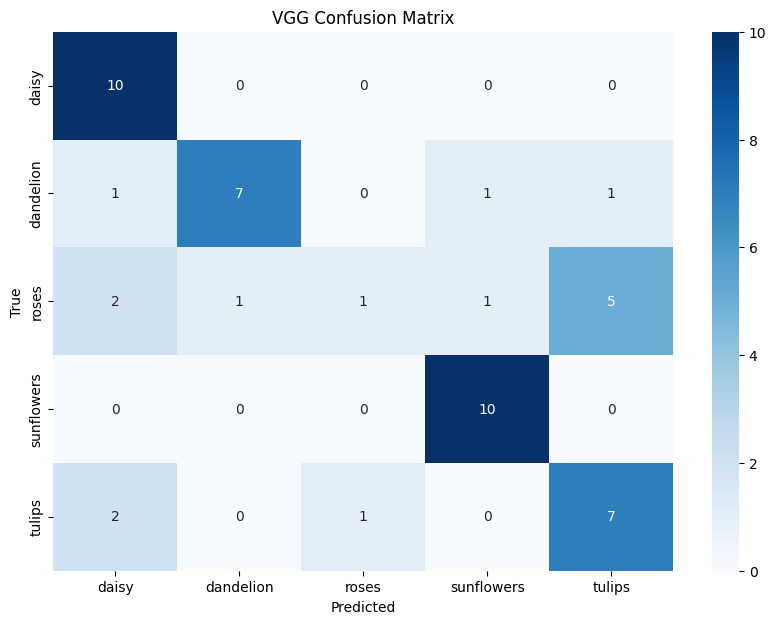

In [28]:
cm = confusion_matrix(y_true_vgg, y_pred_vgg)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("VGG Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

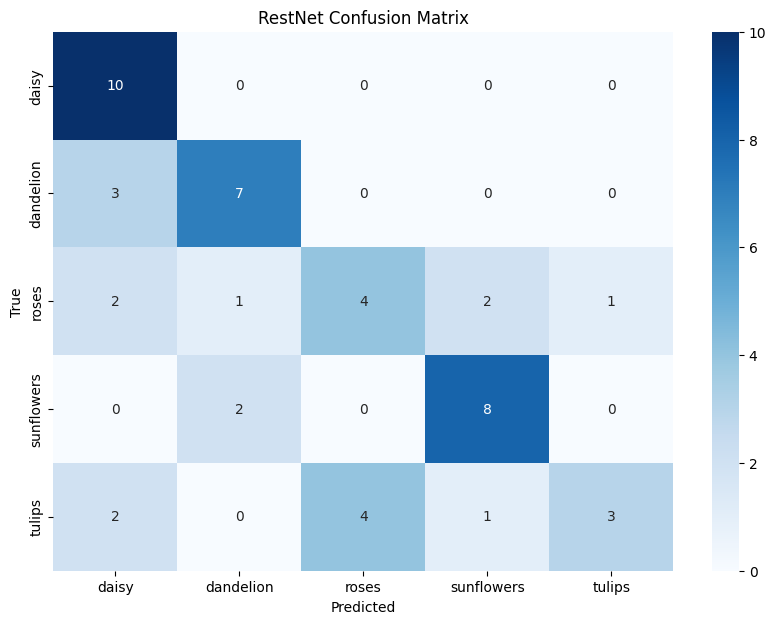

In [29]:
cm = confusion_matrix(y_true_restNet, y_pred_restNet)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("RestNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Then, we plot ROC (Receiver Operating Characteristic) curves for deeper insights. Also we calculate the AUC (Area Under
the Curve) score for each model. 
- **ROC** -> Illustrates the diagnostic ability of a binary classifier by plotting the true positive rate against the false positive rate at various threshold settings.
- **AUC** -> Quantifies the overall performance of the classifier as a single value between 0 and 1, where a higher value indicates better discrimination ability.

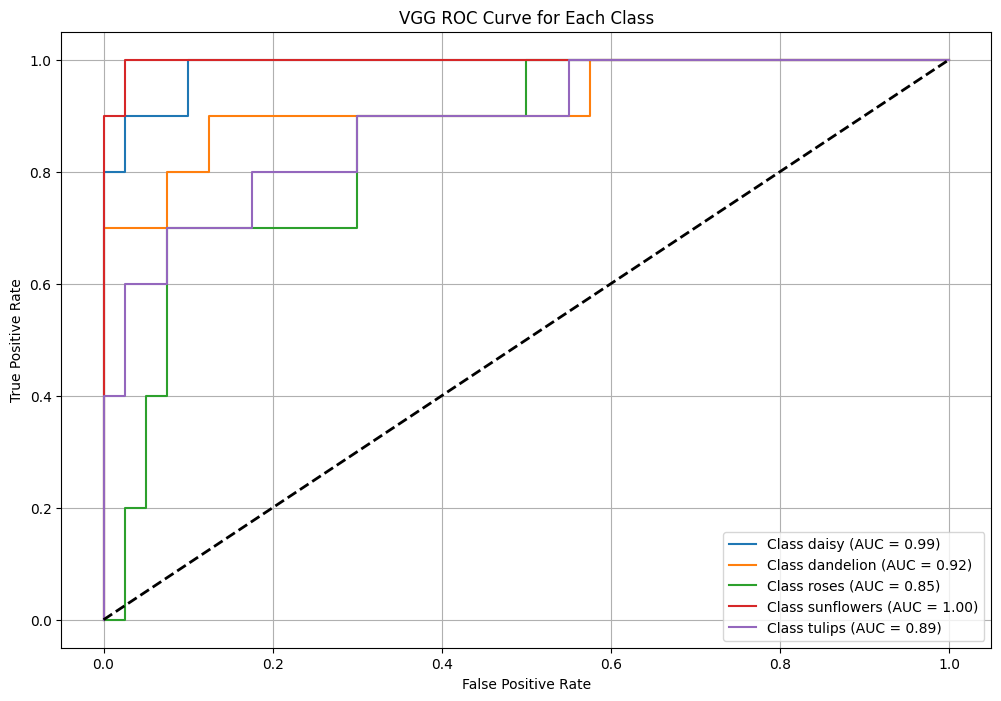

VGG Mean AUC: 0.9290


In [31]:
y_true_bin_vgg = label_binarize(y_true_vgg, classes=range(len(class_names)))

fpr_vgg = dict()
tpr_vgg = dict()
roc_auc_vgg = dict()

for i in range(len(class_names)):
    fpr_vgg[i], tpr_vgg[i], _ = roc_curve(y_true_bin_vgg[:, i], y_prob_vgg[:, i])
    roc_auc_vgg[i] = auc(fpr_vgg[i], tpr_vgg[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    plt.plot(fpr_vgg[i], tpr_vgg[i], label=f"Class {class_names[i]} (AUC = {roc_auc_vgg[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("VGG ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Macro-average AUC
macro_auc_vgg = np.mean(list(roc_auc_vgg.values()))
print(f"VGG Mean AUC: {macro_auc_vgg:.4f}")

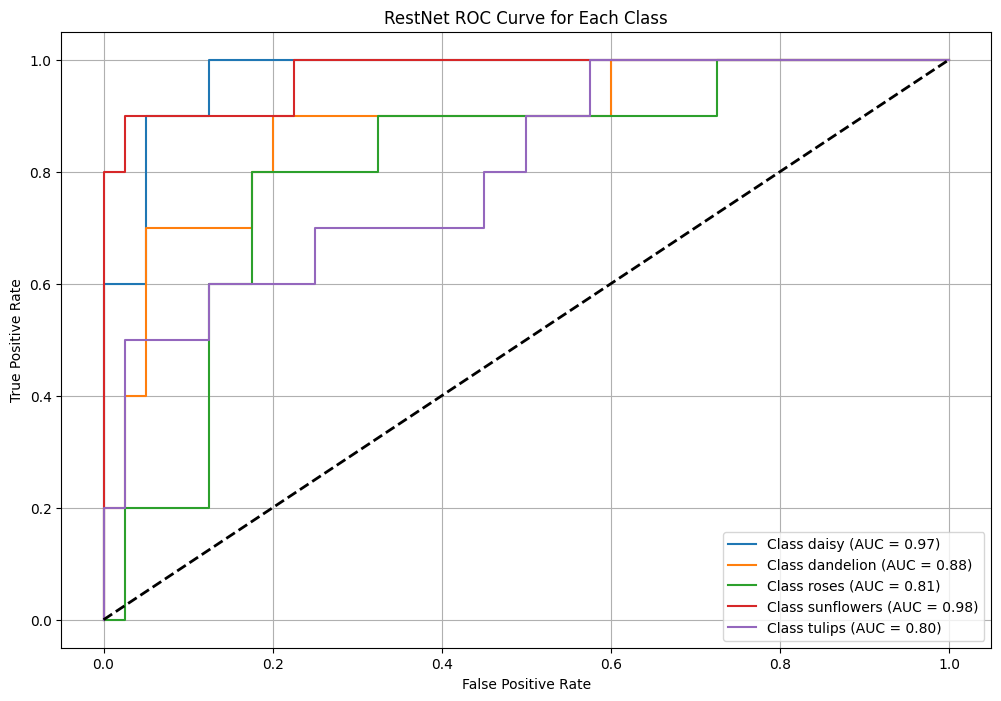

RestNet Mean AUC: 0.8875


In [33]:
y_true_bin_restNet = label_binarize(y_true_restNet, classes=range(len(class_names)))

fpr_restNet = dict()
tpr_restNet = dict()
roc_auc_restNet = dict()

for i in range(len(class_names)):
    fpr_restNet[i], tpr_restNet[i], _ = roc_curve(y_true_bin_restNet[:, i], y_prob_restNet[:, i])
    roc_auc_restNet[i] = auc(fpr_restNet[i], tpr_restNet[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    plt.plot(fpr_restNet[i], tpr_restNet[i], label=f"Class {class_names[i]} (AUC = {roc_auc_restNet[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RestNet ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Macro-average AUC
macro_auc_restNet = np.mean(list(roc_auc_restNet.values()))
print(f"RestNet Mean AUC: {macro_auc_restNet:.4f}")

### 🚀 Questions

***1 - Under what conditions is MLP equivalent to Logistic Regression?***

MLP is equivalent to Logistic Regression under these conditions for Logistic Regression:

- **No Hidden Layers:** The MLP must be a single-layer perceptron, meaning it only has an input layer and an output layer, with no hidden layers in between.
- **Single Output Neuron:** The output layer must contain exactly one neuron. This is because logistic regression is typically used for binary classification (or predicts a single probability).
- **Sigmoid Activation Function:** The activation function used in the single output neuron must be the sigmoid function. The sigmoid function squashes its input into the range (0, 1), which is interpreted as a probability in Logistic Regression.
- **Binary Cross-Entropy Loss:** The model must be trained using a binary cross-entropy loss function. This is the standard loss function for Logistic Regression, measuring the difference between the predicted probabilities and the actual binary outcomes.

***2 - Suppose you have a CNN that begins by taking an input image of size 28 × 28 × 3 and passing through a convolution layer that convolves the image using 3 filters of dimensions 2 × 2 × 3 with valid padding.***

***A. How many learnable parameters does this convolution layer have?***

First we specify these metrics from question:

- $H_{in} = 28$ 
- $W_{in} = 28$
- $C_{in} = 3$ for RGB
- $K = 3$
- $F_h = 2$
- $F_w = 2$
- $F_c = 3$
- No padding

Now we compute learnable parameters for this layer, which consists of weights and biases:
- **Weights per filter** = $F_h \times F_w \times F_c$ = 2 $\times$ 2 $\times$ 3 = 12
- **Bias per filter** = 1

So:
- **Total parameters per filter** = Weights per filter + Bias per filter = 12 + 1 = 13

As a result:
- **Total learnable parameters** = K $\times$ Total parameters per filter = 3 $\times$ 13 = ***39***

***B. Suppose that you instead decided to use a fully connected layer to replicate the behavior of this convolutional layer. How many parameters would that fully connected layer have?***

First we compute dimensions of the output with stride = 1 and padding = 0:

- $H_{out} = (H_{in} - F_h + 2p) / S + 1$ = (28 - 2 + 0) / 1 + 1 = 27
- $W_{out} = (W_{in} - F_w + 2p) / S + 1$ = (28 - 2 + 0) / 1 + 1 = 27
- $C_{out} = K$ = 3

So:
- **Number of output layer neurons** = $H_{out} \times $W_{out} \times $C_{out}$ = 27 $\times$ 27 $\times$ 3 = 2187

Also:
- **Number of input layer neurons** = $H_{in} \times $W_{in} \times $C_{in}$ = 28 $\times$ 28 $\times$ 3 = 2352

Then:
- **Number of weights** = Number of input layer neurons $\times$ Number of output layer neurons = 2352 $\times$ 2187 = 5143824

And we know that:
- **Number of biases** = Number of output layer neurons = 2187

As a result:
- **Total learnable parameters** = Number of weights + Number of biases = 5143824 + 2187 = ***5146011***

***3 - Explain mathematically the vanishing gradient problem in Recurrent Neural Networks (RNNs). Then, analyze how changing the lookback window size impacts the severity of this phenomenon.***

- First we mathematically explane the vanishing gradients in RNNs:

In an RNN, the hidden state $h_t$ at time step $t$ is computed based on the previous hidden state $h_{t-1}$ and the current input $x_t$:
$$h_t = f(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$
where $f$ is an activation function, $W_{hh}$ is the recurrent weights, $W_{xh}$ is the input weights  and $b_h$ is the bias.

The loss $L$ is typically calculated at the final time step $T$. To update the weights, we need to compute the gradient $\frac{\partial L}{\partial W_{hh}}$. This involves the chain rule, propagating gradients backward through time.

Consider the gradient of the loss $L$ with respect to a hidden state $h_k$ at some earlier time step $k < T$:
$$\frac{\partial L}{\partial h_k} = \frac{\partial L}{\partial h_T} \frac{\partial h_T}{\partial h_{T-1}} \frac{\partial h_{T-1}}{\partial h_{T-2}} \dots \frac{\partial h_{k+1}}{\partial h_k}$$

The Jacobian $\frac{\partial h_t}{\partial h_{t-1}}$ is crucial here:
$$\frac{\partial h_t}{\partial h_{t-1}} = \text{diag}(f'(W_{hh}h_{t-1} + W_{xh}x_t + b_h)) W_{hh}^T$$
Let's denote $f'(net_t)$ as $f'_t$. So:
$$\frac{\partial h_t}{\partial h_{t-1}} \approx \text{diag}(f'_t) W_{hh}^T$$

So the gradient $\frac{\partial L}{\partial h_k}$ can be written as:
$$\frac{\partial L}{\partial h_k} = \frac{\partial L}{\partial h_T} \prod_{j=k+1}^{T} \frac{\partial h_j}{\partial h_{j-1}} = \frac{\partial L}{\partial h_T} \prod_{j=k+1}^{T} ( \text{diag}(f'_j) W_{hh}^T)$$

The vanishing gradient problem occurs when the terms in this product, specifically the magnitudes of $\text{diag}(f'_j) W_{hh}^T$, are consistently less than 1. \
As a result, as the number of terms in the product ($T-k$, which is the temporal distance) increases, the product will exponentially shrink towards zero. \
This means that $\frac{\partial L}{\partial h_k}$ becomes very small for distant past states $h_k$. Consequently, the gradients of the loss with respect to the weights $W_{hh}$ (and $W_{xh}$) that were influential at these early time steps also become tiny. \
When gradients are vanishingly small, the weight updates for these earlier time steps are negligible, and the RNN fails to learn long-range dependencies. The model effectively *forgets* information from the distant past. 

- Now we analyze the impact of changing the lookback window size on vanishing gradients:

The "lookback window" (or sequence length) determines how many previous time steps the RNN considers for making a prediction, effectively setting the maximum length $T-k$ over which gradients need to propagate during training for a single sequence.

A **shorter lookback window** makes the RNN less prone to severe vanishing gradients by limiting the propagation depth but restricts its ability to learn long-range patterns.

A **longer lookback window** offers the potential to learn more extended temporal dependencies but exacerbates the vanishing gradient problem, making specialized architectures like LSTMs or GRUs essential for effective training. The choice of lookback window size is therefore a critical hyperparameter that involves a trade-off between computational stability/focus and the capacity to model long-term effects.